# **ESRGAN with TF-GAN**

### **Overview**
This notebook demonstrates the E2E process of data loading, preprocessing, training and evaluation of the [ESRGAN](https://arxiv.org/abs/1809.00219) model using Tensorflow and Tf-GAN on TPUs. To understand the basics of Tf-GAN and explore more features of the library, please visit [Tf-GAN tutorial](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb) notebook first. Please visit the [Google Cloud Tutorial](https://cloud.google.com/storage/docs/creating-buckets) to learn how to create and make use of a cloud storage bucket. 

### **Learning Objectives**
Through this Colab notebook you will learn how to :
* Implement the ESRGAN model and train it
* Make use of various Tf-GAN functions to visualize and evaluate the results. 

### **Steps to run this notebook**


* Click on the following icon to open this notebook in Google Colaboratory. 
> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1j1S5qpSk_GALIdlvGhkdVEvsCNyASbbI?usp=sharing)
* Create a Cloud Storage bucket for storage : http://console.cloud.google.com/storage.
* Navigate to `Runtime > Change runtime type` tab 
* Select TPU from hardware accelerator and save
* Click Connect in the upper right corner and select Connect to hosted runtime.



## Testing out the TPU connection
First, you'll need to enable TPUs for the notebook.

Navigate to Edit→Notebook Settings, and select TPU from the Hardware Accelerator drop-down (you can also access Notebook Settings via the command palette: cmd/ctrl-shift-P).

Next, we'll check that we can connect to the TPU.

In [ ]:
import os
import pprint
import tensorflow as tf
assert 'COLAB_TPU_ADDR' in os.environ, 'Did you forget to switch to TPU?'
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

with tf.compat.v1.Session(tpu_address) as sess:
  devices = sess.list_devices()
pprint.pprint(devices)
device_is_tpu = [True if 'TPU' in str(x) else False for x in devices]
assert True in device_is_tpu, 'Did you forget to switch to TPU?'

### Authentication

To run on Google's free Cloud TPUs, you must set up a Google Cloud Storage bucket to store dataset and model weights during training. New customers to Google Cloud Platform can get $300 dollars in free credits which can come in handy while running this notebook. 

esrgan-bucket-1

In [ ]:
import json
import os
import pprint
import re
import time
import tensorflow
import tensorflow_gcs_config

# Google Cloud Storage bucket for Estimator logs and storing
# the training dataset.
bucket = '' #@param {type:"string"}

assert bucket, 'Must specify an existing GCS bucket name'
print('Using bucket: {}'.format(bucket))

assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'
tpu_address = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

from google.colab import auth
auth.authenticate_user()

# Upload credentials to TPU.
tf.config.experimental_connect_to_host(tpu_address)
tensorflow_gcs_config.configure_gcs_from_colab_auth()
# Now credentials are set for all future sessions on this TPU.

### Check imports

In [ ]:
# Check that imports for the rest of the file work.
import os
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
from tensorflow_gan.examples.esrgan import networks, losses
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
from tensorflow.python.data.experimental import AUTOTUNE

### **Training ESRGAN**
The ESRGAN model proposed in the paper [ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks (Wang Xintao et al.)](https://arxiv.org/abs/1809.00219) performs the task of image super-resolution which is the process of reconstructing high resolution (HR) image from a given low resolution (LR) image. Please go through the paper to have a deeper understanding of the model. 


## Define Parameters


In [7]:
 Params = {
    'batch_size' : 32,
    'hr_dimension' : 256,
    'scale' : 4,
    'data_name': 'div2k/bicubic_x4',
    'trunk_size' : 11,
    'init_lr' : 0.00005,    
    'ph1_steps' : 30000,
    'ph2_steps' : 100000,
    'data_dir' : 'gs://{}/datasets'.format(bucket),
    'model_dir' : 'gs://{}/SavedModels'.format(bucket),
    'decay_ph1' : 0.2,
    'decay_ph2' : 0.5,
    'lambda' : 0.005,
    'eta' : 0.01,
    'val_steps' : 100
}

## Load Training Dataset
We have used the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset which is usually used for benchmarking super resolution models. DIV2K dataset provides various kinds of image from which we are downloading only the HR images and corresponding LR images downsampled using bicubic downsampling. All the HR images are also scaled to 96 x 96 and LR images to 28 x 28.    

In [8]:
dataset_dir = Params['data_dir']

def input_fn(mode, params):
  assert 'batch_size' in params
  bs = params['batch_size']
  split = 'train' if mode == 'train' else 'validation'
  shuffle = True 

  def scale(image, *args):
    hr_size = params['hr_dimension']
    scale = params['scale']

    hr_image = image
    hr_image = tf.image.resize(hr_image, [hr_size, hr_size])
    lr_image = tf.image.resize(hr_image, [hr_size//scale, hr_size//scale], method='bicubic')
    
    hr_image = tf.clip_by_value(hr_image, 0, 255)
    lr_image = tf.clip_by_value(lr_image, 0, 255)
    
    return lr_image, hr_image

  dataset = (tfds.load(params['data_name'], split=split, data_dir=dataset_dir, as_supervised=True)
             .map(scale, num_parallel_calls=4)
             .cache()
             .repeat())
  if shuffle:
    dataset = dataset.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  dataset = (dataset.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))
  
  return dataset

In [36]:
train_ds = input_fn(mode='train', params=Params)

In [37]:
val_ds = input_fn(mode='validation', params=Params)

## Visualize the dataset

In [ ]:
img_lr, img_hr = next(iter(train_ds))
lr = Image.fromarray(np.array(img_lr)[0].astype(np.uint8))
lr = lr.resize([256, 256])
display(lr)

hr = Image.fromarray(np.array(img_hr)[0].astype(np.uint8))
hr = hr.resize([256, 256])
display(hr)

## Network Architecture
The basic network buidling unit of the  ESRGAN is the Residual-in-Residual Block (RRDB) without batch normalization. The network implemented is similar to the architecture proposed in the paper.


In [12]:
from keras.models import Model
from keras.layers import Input, Add, Conv2D
from keras.layers import LeakyReLU, Flatten, BatchNormalization, Dense

### Generator Network

In [13]:
def ESRGAN_G(filter=32, trunk_size = Params['trunk_size'], out_channels = 3):
    lr_input = Input(shape=(None, None, 3))
    
    x = Conv2D(filter, kernel_size=[3,3], strides=[1,1], padding='same', use_bias = True)(lr_input)
    x = LeakyReLU(0.2)(x)

    ref = x
    
    for _ in range(trunk_size):
        x = networks.RRDB(x)

    x = Conv2D(filter, kernel_size=[3,3], strides=[1,1], padding='same', use_bias = True)(x)
    x = Add()([x, ref])

    x = networks.upsample(x, filter)
    x = networks.upsample(x, filter)
    
    x = Conv2D(filter, kernel_size=3, strides=1, padding='same', use_bias = True)(x)
    x = LeakyReLU(0.2)(x)
    hr_output = Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias = True)(x)

    model = Model(inputs=lr_input, outputs=hr_output)
    return model

### Discriminator Network


In [14]:
def ESRGAN_D(filters = 64, training=True):
    img = Input(shape = (256, 256, 3))
    
    x = Conv2D(filters, [3,3], 1, padding='same', use_bias=False)(img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters, [3,3], 2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = networks._conv_block_d(x, filters *2)
    x = networks._conv_block_d(x, filters *4)
    x = networks._conv_block_d(x, filters *8)
    
    x = Flatten()(x)
    x = Dense(100)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1)(x)

    model = Model(inputs = img, outputs = x)
    return model

## Training
ESRGAN model is trained in two phases in which the first phase deals with training the generator network individually and is aimed at improving the PSNR values of generated images by reducing the L1 loss.  

Training of the same generator model is continued in the second phase along with the discriminator network. In the second phase, the generator reduces the L1 Loss, Relativistic average GAN (RaGAN) loss which indicates how realistic does the generated image look and the imporved Perceptual loss proposed in the paper.  


In [15]:
# To display images in the order : LR Image -> Generated Image -> HR Image
def visualize_results(image_lr, generated, image_hr):
    size = 180
    resized_lr = tf.image.resize(image_lr, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_gen = tf.image.resize(generated, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_hr = tf.image.resize(image_hr, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    stack = tf.stack([resized_lr[0], resized_gen[0], resized_hr[0]])
    image_grid = tfgan.eval.python_image_grid(stack, grid_shape=(1, 3))
    result = Image.fromarray(image_grid.astype(np.uint8))
    return result

In [ ]:
# Define the TPU strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

### Phase - 1 Training

Steps Involved:

* Define the generator and its optimizer. 
* Take LR, HR image pairs from the training dataset
* Input the LR image to the generator network
* Calculate the L1 loss using the generated image and HR image
* Calculate gradient value and apply it to the optimizer
* Update the learning rate of optimizer after every decay steps for better performance

In [17]:
with strategy.scope():
  metric = tf.keras.metrics.Mean()
  psnr_metric = tf.keras.metrics.Mean()

  generator = ESRGAN_G()

  G_optimizer = tf.optimizers.Adam(
      learning_rate = 0.0002,
      beta_1 = 0.9,
      beta_2 = 0.99
  )

In [15]:
@tf.function
def train_step(image_lr, image_hr):
  with tf.GradientTape() as tape:
    fake = generator(image_lr)
    loss = losses.pixel_loss(image_hr, fake) * (1.0 / Params['batch_size'])
    psnr_loss = tf.image.psnr(fake, image_hr,max_val = 256.0)
 
    metric(loss)

    gradient = tape.gradient(loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))

    return psnr_loss

def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

In [16]:
train_ds = iter(strategy.experimental_distribute_dataset(train_ds))

In [ ]:
total_steps = Params['ph1_steps']
step_count = 1

while step_count < total_steps:
  lr, hr = next(train_ds)
  psnr_loss = strategy.run(train_step, args = (lr, hr))
  loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, psnr_loss, axis=None)
  psnr_metric(loss)
  
  if step_count%10000 == 0:
    lr = np.array(lr.values)[0]
    hr = np.array(hr.values)[0]
    print("step {}      PNSR = {}".format(step_count, psnr_metric.result()))
    val_steps(lr, hr) 
  
  if step_count%5000 == 0:
    G_optimizer.learning_rate.assign(
        G_optimizer.learning_rate * Params['decay_ph1'])
  step_count+=1

If you want to save the generator network use 'model.save' function to do so and since TPU is beings used the model has to be saved inside the cloud storage bucket. 

In [ ]:
os.makedirs(Params['model_dir'] + '/Phase_1.1/generator', exist_ok = True)
generator.save(Params['model_dir'] + '/Phase_1.1/generator')


###**Phase - 2**

* Load the generator network trained in Phase 1
* Load the discriminator
* Define RaGAN loss and Perceptual loss
* Take LR, HR image pairs from the training dataset
* Input the LR image to the generator network
* Using the generated image and HR image calcualte L1 loss, Perceptual loss and RaGAN loss for both generator and discriminator.
* Update the optimizer for both networks using the obtained gradient values
* Update the learning rate of optimizers after every decay steps for better performance
* Tf-GAN's image grid function is used to display the generated images during training. 

In [18]:
with strategy.scope():
  optimizer = tf.optimizers.Adam(
      learning_rate = 0.0002,
      beta_1 = 0.9,
      beta_2 = 0.99
  )
  generator = tf.keras.models.load_model(Params['model_dir'] + '/Phase_1.1/generator/')
  discriminator = ESRGAN_D()

  G_optimizer = optimizer
  G_optimizer.learning_rate.assign(Params['init_lr'])
  D_optimizer = optimizer

In [ ]:
with strategy.scope():
  ra_gen = losses.RealitivisticAverageLoss(discriminator, type_ = "G")
  ra_disc = losses.RealitivisticAverageLoss(discriminator, type_ = "D")
  
  perceptual_loss = losses.PerceptualLoss(
        weight = "imagenet",
        input_shape = [Params['hr_dimension'], Params['hr_dimension'], 3],
        loss_type = 'L1'
    )

In [22]:
with strategy.scope():
  gen_metric = tf.keras.metrics.Mean()
  disc_metric = tf.keras.metrics.Mean()
  psnr_metric = tf.keras.metrics.Mean()

In [23]:
def preprocess_input(image):
    image = image[..., ::-1]
    mean = -tf.constant([103.939, 116.779, 123.68])
    return tf.nn.bias_add(image, mean)

In [24]:
@tf.function
def train_step(image_lr, image_hr):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     pred = generator(image_lr)
     
     fake = preprocess_input(pred)
     image_lr = preprocess_input(image_lr)
     image_hr = preprocess_input(image_hr)
     
     percep_loss = tf.reduce_mean(perceptual_loss(image_hr, fake))
     l1_loss = losses.pixel_loss(image_hr, fake) 
     loss_RaG = ra_gen(image_hr, fake) 

     disc_loss = ra_disc(image_hr, fake)
     gen_loss = percep_loss + Params['lambda'] * loss_RaG + Params['eta'] * l1_loss

     gen_loss = gen_loss * (1.0 / Params['batch_size'])
     disc_loss = disc_loss * (1.0 / Params['batch_size'])
     psnr_loss = tf.image.psnr(fake, image_hr, max_val = 256.0)
     
     disc_metric(disc_loss) 
     gen_metric(gen_loss)
     psnr_metric(psnr_loss)
     
     disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
     D_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

     gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables) 
     G_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
     
     return [disc_loss, gen_loss, psnr_loss]

def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

In [25]:
train_ds = iter(strategy.experimental_distribute_dataset(train_ds))

In [ ]:
total_steps = 100000
step_count = 0

decay_step = [9000, 30000, 80000, 100000]
decay_factor = 0.5

while step_count < total_steps:
  lr, hr = next(train_ds)
  disc_loss, gen_loss, psnr_loss  = strategy.run(train_step, args = (lr, hr))

  if step_count % 10000 == 0:
    print("step {}".format(step_count) + "   Generator Loss = {}   ".format(gen_metric.result()) + 
        "Disc Loss = {}".format(disc_metric.result()) + "   PSNR : {}".format(psnr_metric.result()))
    lr = np.array(lr.values)[0]
    hr = np.array(hr.values)[0]
    val_steps(lr, hr) 
  
  step_count+=1
  
  if step_count >= decay_step[0]:
    decay_step.pop(0)
    G_optimizer.learning_rate.assign(
            G_optimizer.learning_rate * Params['decay_ph2'])
  
    D_optimizer.learning_rate.assign(
        D_optimizer.learning_rate * Params['decay_ph2'])

In [ ]:
os.makedirs(Params['model_dir'] + '/Phase_2.1/generator', exist_ok = True)
generator.save(Params['model_dir'] + '/Phase_2.1/generator')

In [ ]:
os.makedirs(Params['model_dir'] + '/Phase_2.1/discriminator', exist_ok = True)
discriminator.save(Params['model_dir'] + '/Phase_2.1/discriminator')

###**Network Interpolation**
Network Interpolation as explained in the paper is used to balance the effect of the generator trained during phase 1 and phase 2. 

In [27]:
def network_interpolation(alpha=0.2,
                          phase_1_path=None,
                          phase_2_path=None):

  psnr_gen = tf.keras.models.load_model(phase_1_path)
  gan_gen = tf.keras.models.load_model(phase_2_path)

  for var_1, var_2 in zip(gan_gen.trainable_variables, 
                          psnr_gen.trainable_variables):
    var_1.assign((1 - alpha) * var_2 + alpha * var_1)

  return gan_gen

In [31]:
generator = network_interpolation(phase_1_path = Params['model_dir'] + '/Phase_2.1/generator',
                                  phase_2_path = Params['model_dir'] + '/Phase_1.1/generator')

## Evaluation



### Visualize Generated Images


In [32]:
def val_steps(image_lr, image_hr):
  fake = generator(image_lr)
  result = visualize_results(image_lr, fake, image_hr)
  display(result)

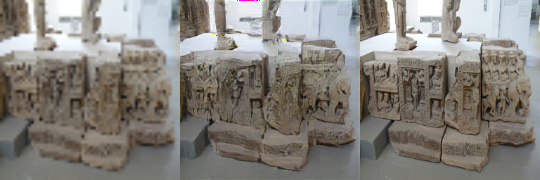

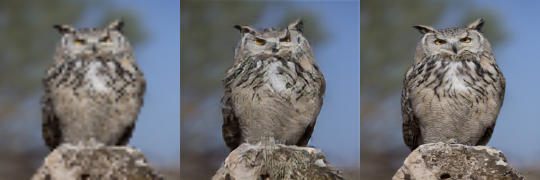

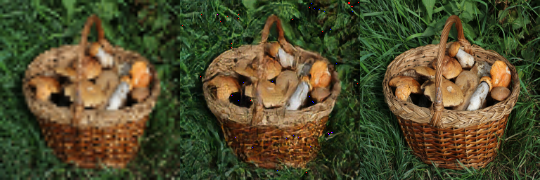

In [34]:
for i in range(3):
  lr, hr = next(iter(val_ds))
  val_steps(lr, hr) 

### Calculate FID and Inception Scores

FID and Inception Scores are two common metrices used to evaluate the performance of a GAN model and PSNR value is used to quantify the similarity between two images and is used for benchmarking super resolution models. 

In [ ]:
@tf.function
def get_fid_score(real_image, gen_image):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

  resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  
  num_inception_images = 1
  num_batches = Params['batch_size'] // num_inception_images
  
  fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images, num_batches=num_batches)
  return fid
  
@tf.function
def get_inception_score(images, num_inception_images = 8):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
  resized_images = tf.image.resize(images, [size, size], method=tf.image.ResizeMethod.BILINEAR)

  num_batches = Params['batch_size'] // num_inception_images
  inc_score = tfgan.eval.inception_score(resized_images, num_batches=num_batches)

  return inc_score

In [ ]:
with strategy.scope():
  fid_metric = tf.keras.metrics.Mean()
  inc_metric = tf.keras.metrics.Mean()
  psnr_metric = tf.keras.metrics.Mean()

In [ ]:
count = 0
i = 0
while i < Params['val_steps']: 
  lr, hr = next(iter(val_ds))

  gen = generator(lr)
  
  fid = strategy.run(get_fid_score, args = (hr, gen))
  real_is = strategy.run(get_inception_score, args=(hr))
  gen_is = strategy.run(get_inception_score, args=(gen))

  fid_metric(fid)
  inc_metric(gen_is)
  psnr_metric(tf.reduce_mean(tf.image.psnr(gen, hr, max_val = 256.0)))